In [3]:
import numpy as np
from pyuvdata import UVBeam
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sparse_beam import sparse_beam

## Table of contents

* [Vivaldi efield](#vivaldi_efield). Show parameters only
* [Vivaldi power](#vivaldi_power). Show parameters and plot the beam (easy to plot power beam)
* [RHINO matlab](#rhino_matlab). Plot the beam from the matlab files
* [RHINO UVBeam](#rhino_uvbeam). Plot the beam from a UVBeam file generated from the matlab files

In [4]:
class Grid:
    def __init__(self, dim):
        self.grid = np.zeros((dim, dim))  
        self.dim = dim
        self.num = np.zeros((dim, dim), dtype=int)
        
    def insert(self, x, y, val):   # the physical values range from -1 to 1
        i = np.trunc(np.interp(x, [-1, 1], [0, self.dim-1])).astype(int)
        j = np.trunc(np.interp(y, [-1, 1], [0, self.dim-1])).astype(int)
    
        for k in range(val.size):
            self.grid[i[k], j[k]] += val[k]
            self.num[i[k], j[k]] += 1
        
        """
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j]>0 and self.num[i][j] == 0: print("G")
                if self.grid[i, j]==0 and self.num[i][j] > 0: print("G")
        """      

    def insert1(self, x, y, val):   # the physical values range from -1 to 1
        i = np.trunc(np.interp(x, [-1, 1], [0, self.dim-1])).astype(int)
        j = np.trunc(np.interp(y, [-1, 1], [0, self.dim-1])).astype(int)
        
        self.grid[i, j] += val
        self.num[i, j] += 1
    
            
    def average(self):
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j] > 0:
                    self.grid[i, j] /= self.num[i, j]

        #self.grid = np.where(self.grid>0, self.grid/self.num, self.grid)

        
    def log10(self):
        vmin = 1e9
        for i in range(self.dim):
            for j in range(self.dim):
                if self.grid[i, j] > 0:
                    self.grid[i, j] = np.log10(self.grid[i, j])
                    if self.grid[i, j] < vmin: vmin = self.grid[i, j]
                else:
                    self.grid[i, j] = np.nan
                    
        return vmin
        #self.grid = np.where(self.grid>0, np.log10(self.grid), self.grid)
    
    def dB(self):
        vmin = self.log10()
        vmin *= 10
        self.grid *= 10
        return vmin


In [5]:
def print_UVBeam(uvb):
    print("Naxes_vec", uvb.Naxes_vec)
    print("Nfreqs", uvb.Nfreqs)
    print("antenna_type", uvb.antenna_type)
    print("bandpass_array shape", uvb.bandpass_array.shape)
    print("bandpass_array", uvb.bandpass_array)
    print("beam_type", uvb.beam_type)
    print("data_array shape", uvb.data_array.shape)
    if uvb.future_array_shapes:
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, Nfeeds or Npols, Nfreqs, Npixels)")
        else:
            print("\t(Naxes_vec, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)")
    else:
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Npixels)")
        else:
            print("\t(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)")
       
    
    print("data_normalization", uvb.data_normalization)
    print("feed_name", uvb.feed_name)
    print("feed_version", uvb.feed_version)
    print("freq_array", uvb.freq_array)
    print("future_array_shapes", uvb.future_array_shapes)
    print("history", uvb.history)
    print("model_name", uvb.model_name)
    print("model_version", uvb.model_version)
    print("pixel_coordinate_system", uvb.pixel_coordinate_system)
    print("telescope_name", uvb.telescope_name)
    
    print("------------------------------------------------------")
    
    
    print("Naxes1", uvb.Naxes1)
    print("Naxes2", uvb.Naxes2)
    print("Ncomponents_vec", uvb.Ncomponents_vec)
    print("Nelements", uvb.Nelements)
    print("Nfeeds", uvb.Nfeeds)
    print("Npixels", uvb.Npixels)
    print("Npols", uvb.Npols)
    print("Nspws", uvb.Nspws)
    print("axis1_array shape", uvb.axis1_array.shape)
    print("axis2_array shape", uvb.axis2_array.shape)
    if uvb.basis_vector_array is not None: 
        print("basis_vector_array shape ", uvb.basis_vector_array.shape)
        if uvb.beam_type == "healpix":
            print("\t(Naxes_vec, Ncomponents_vec, Npixels)")
        else:
            print("\t(Naxes_vec, Ncomponents_vec, Naxes2, Naxes1)")
    else: print("uvb.basis_vector_array None")
    print("coupling_matrix", uvb.coupling_matrix)
    print("delay_array", uvb.delay_array)
    print("element_coordinate_system", uvb.element_coordinate_system)
    print("element_location_array", uvb.element_location_array)
    print("extra_keywords", uvb.extra_keywords)
    print("feed_array", uvb.feed_array)
    print("filename", uvb.filename)
    print("freq_interp_kind", uvb.freq_interp_kind)
    print("gain_array", uvb.gain_array)
    print("loss_array", uvb.loss_array)
    print("mismatch_array", uvb.mismatch_array)
    print("nside", uvb.nside)
    print("ordering", uvb.ordering)
    print("pixel_array", uvb.pixel_array)
    print("polarization_array", uvb.polarization_array)
    print("receiver_temperature_array", uvb.receiver_temperature_array)
    print("reference_impedance", uvb.reference_impedance)
    print("s_parameters", uvb.s_parameters)
    print("spw_array", uvb.spw_array)
    print("x_orientation", uvb.x_orientation)
    print("-----------------------------------")

<a id='vivaldi_efield'></a>
## Vivaldi efield beam

Don't know how to plot this (can plot power beam later). However can print parameters.

In [6]:
uvb = UVBeam()
uvb.read("/scratch3/users/hgarsden/local/hgarsden/NF_HERA_Vivaldi_efield_beam.fits")


Print the efield beam parameters, plus some values if arrays are not too big.

In [7]:
print_UVBeam(uvb)

Naxes_vec 2
Nfreqs 201
antenna_type simple
bandpass_array shape (1, 201)
bandpass_array [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1.]]
beam_type efield
data_array shape (2, 1, 2, 201, 181, 360)
	(Naxes_vec, 1, Nfeeds or Npols, Nfreqs, Naxes2, Naxes1)
data_normalization physical
feed_name Vivaldi
feed_version 1.0
freq_array [[5.00e+07 5.10e+07 5.20e+07 5.30e+07 5.40e+07 5.50e+07 5.60e+07 5.70e+07
  5.80e+07 5.90e+07 6.00e

<a id='vivaldi_power'></a>
### Vivaldi Power beam

Power beam can easily be plotted.

In [8]:
uvbp = UVBeam()
uvbp.read("/scratch3/users/hgarsden/local/hgarsden/NF_HERA_Vivaldi_power_beam.fits")


Print the power beam parameters, plus some values if arrays are not too big.

In [9]:
print_UVBeam(uvbp)

Naxes_vec 1
Nfreqs 201
antenna_type simple
bandpass_array shape (1, 201)
bandpass_array [[  571.6881   624.5001   673.4025   716.6329   754.0516   784.5601
    807.1281   821.3956   827.1376   826.5625   821.3956   813.3904
    804.8569   796.9329   790.1721   785.6809   784.       786.2416
    793.5489   807.6964   830.0161   861.4225   903.0025   954.81
   1017.61    1092.3025  1177.1761  1268.7844  1366.0416  1466.1241
   1564.9936  1658.1184  1744.7329  1824.9984  1904.4496  1982.9209
   2063.8849  2145.5424  2227.84    2310.7249  2396.1025  2486.0196
   2583.6889  2689.4596  2806.8804  2931.1396  3060.3024  3186.6025
   3303.9504  3400.0561  3465.6769  3493.9921  3484.5409  3449.2129
   3404.7225  3369.8025  3357.0436  3373.2864  3417.5716  3484.5409
   3567.6729  3659.0401  3751.5625  3836.5636  3913.7536  3981.61
   4048.7769  4121.64    4212.01    4329.64    4476.9481  4647.1489
   4824.6916  4992.8356  5139.4561  5262.0516  5365.5625  5459.7321
   5554.7209  5661.0576  5785.12


Plot the Vivaldi power beam

(65160,) (65160,)


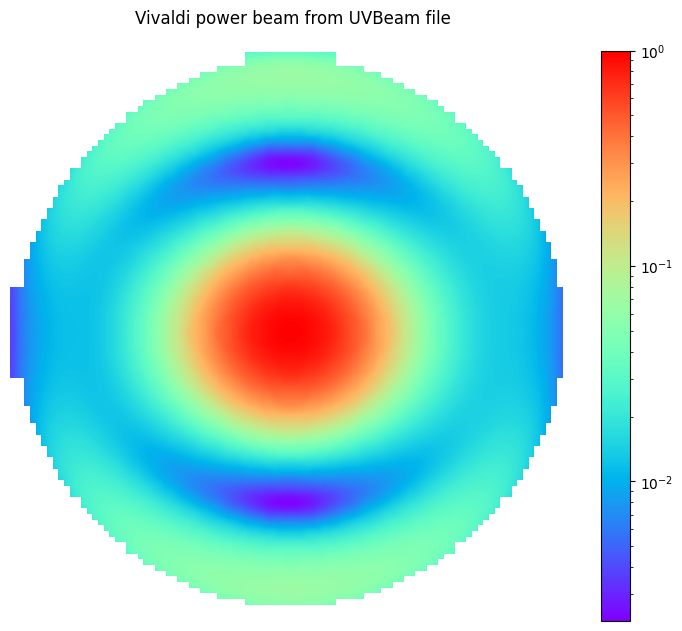

In [10]:
uvbp.interpolation_function = "az_za_simple"
uvbp.freq_interp_kind = "linear"

azimuth = uvbp.axis1_array
zen_angle = uvbp.axis2_array

az = np.tile(azimuth, zen_angle.size)
za = np.repeat(zen_angle, azimuth.size)
print(az.shape, za.shape)
za_ok = za<=np.deg2rad(90)
az = az[za_ok]
za = za[za_ok]

interp_beam = uvbp.interp(az, za, freq_array=np.array([60e+06]))[0]
interp_beam = interp_beam[0, 0, 0, 0]       
values = interp_beam   


grid = Grid(100)
r = np.sin(za)
x = r*np.sin(az)
y = r*np.cos(az)

grid.insert(-x, y, values)
grid.average()
grid.grid = np.where(grid.grid==0, np.nan, grid.grid)


plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid.grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("Vivaldi power beam from UVBeam file\n")
plt.savefig("vivaldi_uvbeam")

<a id='rhino_matlab'></a>
## RHINO Beam from matlab

Use the data from the files. From the el and az, calculate points on an x/y grid and insert power values (if more than 1 value goes to an x/y point they are averaged). The matlab values are assumed to be dB so they are converted to values 10**(dB/10). Then the values are plotted on log scale.

There are positive and negative el in the matlab files. I only use el > =0.

The el/az have to be rotated because the beam is pointing at the horizon.

[0.000000e+00 6.123234e-17 1.000000e+00]
[1.5707963267948966, 0.0]
el shape (181,)
az shape (361,)
values shape (181, 361)


invalid value encountered in divide


'\nim = plt.imshow(np.loadtxt("matlab_horn_351MHz.dat"))\nplt.yticks([0, 45, 90, 135, 180], [0-90, 45-90, 90-90, 135-90, 180-90])\nplt.xlabel("az")\nplt.ylabel("el")\n'

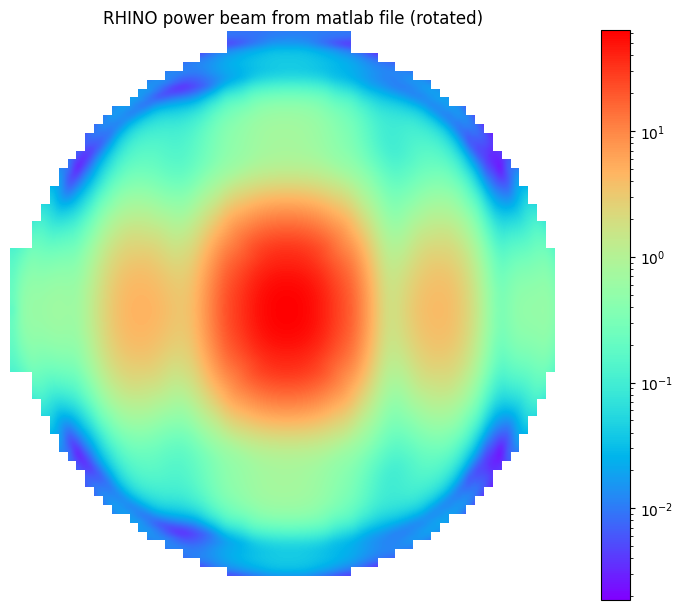

In [11]:
def rotate(X, theta, axis='x'):
  '''Rotate multidimensional array `X` `theta` degrees around axis `axis`'''
  c, s = np.cos(theta), np.sin(theta)
  if axis == 'x': return np.dot(X, np.array([
    [1.,  0,  0],
    [0 ,  c, -s],
    [0 ,  s,  c]
  ]))
  elif axis == 'y': return np.dot(X, np.array([
    [c,  0,  -s],
    [0,  1,   0],
    [s,  0,   c]
  ]))
  elif axis == 'z': return np.dot(X, np.array([
    [c, -s,  0 ],
    [s,  c,  0 ],
    [0,  0,  1.],
  ]))

def to_xyz(el, az):
    
    r = np.cos(el)
    x = r*np.sin(az)
    y = r*np.cos(az)  
    z = np.sin(el)

    return [x, y, z]

def to_el_az(xyz):
    el = np.arcsin(xyz[2])
    az = np.arctan2(xyz[0], xyz[1])
    return [el, az]



v = to_xyz(0, 0)
th = np.deg2rad(-90)
v = rotate(v, th, axis="x")
print(v)
print(to_el_az(v))

with open("matlab_horn_351MHz_az.dat", "r") as f:
    az = np.deg2rad(np.array(f.readline()[:-1].split(","), dtype=float))

with open("matlab_horn_351MHz_el.dat", "r") as f:
    el = np.deg2rad(np.array(f.readline()[:-1].split(","), dtype=float))

values = np.loadtxt("matlab_horn_351MHz.dat")   # el by az
values = 10**(values/10)

print("el shape",el.shape)
print("az shape", az.shape)
print("values shape", values.shape)

all_az = []
all_el = []
all_values = []
# Grid the values
rotate_theta = np.deg2rad(-90)
grid = np.zeros((64, 64))    
nums = np.zeros((64, 64))     # For averaging
for i in range(len(el)):
    for j in range(len(az)):
        
        v = to_xyz(el[i], az[j])
        v = rotate(v, rotate_theta, axis="x")
        el_az = to_el_az(v)
        new_el = el_az[0]
        new_az = el_az[1]
        all_az.append(new_az)
        all_el.append(new_el)
        all_values.append(values[i, j])
        #new_el = el[i]
        #new_az = az[j]
        
        if new_el > 0:
            r = np.cos(new_el)
            x = r*np.sin(new_az)
            y = r*np.cos(new_az)  
    
            # convert the x/y points to a grid location. x/y can be -1 to 1
            gi = int(np.trunc(np.interp(x, [-1, 1], [0, 63])))
            gj = int(np.trunc(np.interp(y, [-1, 1], [0, 63])))
            grid[gi, gj] += values[i, j]
            nums[gi, gj] += 1

np.savez("/tmp/all.npz", all_az=np.array(all_az), all_el=np.array(all_el), all_values=np.array(all_values))
grid = np.where(grid<=0, np.nan, grid/nums)

plt.figure(figsize=(8, 8))


ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from matlab file (rotated)")
plt.savefig("rhino_matlab")
"""
im = plt.imshow(np.loadtxt("matlab_horn_351MHz.dat"))
plt.yticks([0, 45, 90, 135, 180], [0-90, 45-90, 90-90, 135-90, 180-90])
plt.xlabel("az")
plt.ylabel("el")
"""
#plt.colorbar(im,fraction=0.023, pad=0.04)


invalid value encountered in divide


'\nim = plt.imshow(np.loadtxt("matlab_horn_351MHz.dat"))\nplt.yticks([0, 45, 90, 135, 180], [0-90, 45-90, 90-90, 135-90, 180-90])\nplt.xlabel("az")\nplt.ylabel("el")\n'

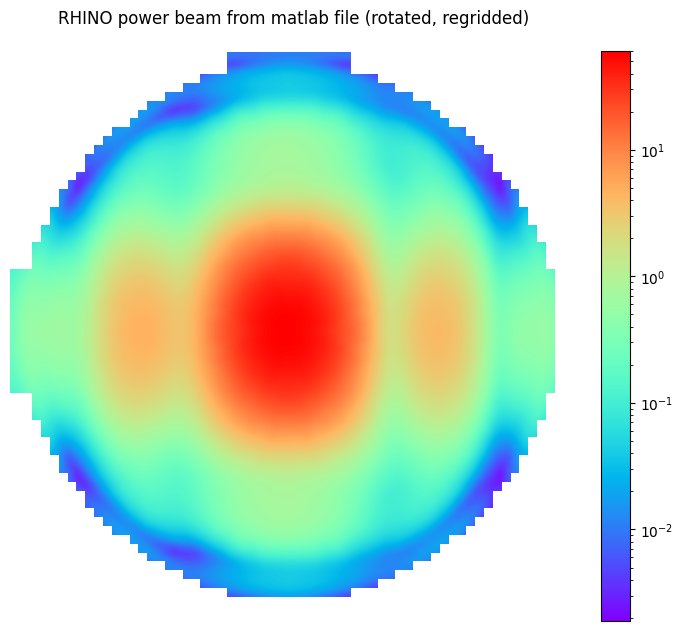

In [12]:
from scipy.interpolate import griddata

data = np.load("all.npz")
az = np.rad2deg(data["all_az"])
el = np.rad2deg(data["all_el"])
power = data["all_values"]

points = np.column_stack((el, az))


xi_az = np.tile(np.arange(-180, 181, dtype=int), 181)
xi_el = np.repeat(np.arange(-90, 91, dtype=int), 361)
xi = np.column_stack((xi_el, xi_az))


interpolated_power = griddata(points, power, xi, method="nearest")

# Dump new files. Need to normalize the az/el to az/za with correct values around the circle
ip_grid = np.zeros((181, 361))
for i in range(len(xi)):
    # make the az go from 0 to 360
    az = xi[i][1]
    if az < 0: az += 360
    # convert el to za and make from 0 to 180
    za = 90-xi[i][0]                     # nothing else to do

    ip_grid[int(za), int(az)] = interpolated_power[i]

za = ",".join([ str(i) for i in range(181) ])
with open("./matlab_horn_351MHz_rot_za.dat", "w") as f:
    f.write(za+"\n")
az = ",".join([ str(i) for i in range(361) ])
with open("./matlab_horn_351MHz_rot_az.dat", "w") as f:
    f.write(az+"\n")

np.savetxt("matlab_horn_351MHz_rot.dat", ip_grid)
# ---------------------------------------------------

grid = np.zeros((64, 64))    
nums = np.zeros((64, 64))     # For averaging
for i in range(len(xi)):
        
        el = np.deg2rad(xi[i][0])
        az = np.deg2rad(xi[i][1])
        
        if el > 0:
            r = np.cos(el)
            x = r*np.sin(az)
            y = r*np.cos(az)  
    
            # convert the x/y points to a grid location. x/y can be -1 to 1
            gi = int(np.trunc(np.interp(x, [-1, 1], [0, 63])))
            gj = int(np.trunc(np.interp(y, [-1, 1], [0, 63])))
            grid[gi, gj] += interpolated_power[i]
            nums[gi, gj] += 1

grid = np.where(grid<=0, np.nan, grid/nums)

plt.figure(figsize=(8, 8))


ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from matlab file (rotated, regridded)\n")
plt.savefig("rhino_matlab")
"""
im = plt.imshow(np.loadtxt("matlab_horn_351MHz.dat"))
plt.yticks([0, 45, 90, 135, 180], [0-90, 45-90, 90-90, 135-90, 180-90])
plt.xlabel("az")
plt.ylabel("el")
"""
#plt.colorbar(im,fraction=0.023, pad=0.04)


<a id='rhino_uvbeam'></a>
## RHINO Beam as UVBeam

Create a UVBeam object from the RHINO beam matlab files and load the UVBeam object.

The UVBeam has been given 208 frequencies because that is used in further simulations. The beam has been made identical for every frequency (wrong).

In [13]:
rhino = UVBeam()
rhino.read("/users/hgarsden/rhino-sim/rhino_matlab1.beamfits")
print(rhino.axis2_array)

[0.         0.01745329 0.03490659 0.05235988 0.06981317 0.08726646
 0.10471976 0.12217305 0.13962634 0.15707963 0.17453293 0.19198622
 0.20943951 0.2268928  0.2443461  0.26179939 0.27925268 0.29670597
 0.31415927 0.33161256 0.34906585 0.36651914 0.38397244 0.40142573
 0.41887902 0.43633231 0.45378561 0.4712389  0.48869219 0.50614548
 0.52359878 0.54105207 0.55850536 0.57595865 0.59341195 0.61086524
 0.62831853 0.64577182 0.66322512 0.68067841 0.6981317  0.71558499
 0.73303829 0.75049158 0.76794487 0.78539816 0.80285146 0.82030475
 0.83775804 0.85521133 0.87266463 0.89011792 0.90757121 0.9250245
 0.9424778  0.95993109 0.97738438 0.99483767 1.01229097 1.02974426
 1.04719755 1.06465084 1.08210414 1.09955743 1.11701072 1.13446401
 1.15191731 1.1693706  1.18682389 1.20427718 1.22173048 1.23918377
 1.25663706 1.27409035 1.29154365 1.30899694 1.32645023 1.34390352
 1.36135682 1.37881011 1.3962634  1.41371669 1.43116999 1.44862328
 1.46607657 1.48352986 1.50098316 1.51843645 1.53588974 1.55334

Print rhino beam parameters and some values.

In [14]:
print_UVBeam(rhino)

Naxes_vec 1
Nfreqs 280
antenna_type simple
bandpass_array shape (1, 280)
bandpass_array [[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
beam_type power
data_array shape (1, 1, 2, 280

Plot the RHINO beam from the UVBeam files using the same method as for the Vivaldi power beam.

(360,) (180,)
(64800,) (64800,)
[64.12166548 64.12166548 64.12166548 64.12166548 64.12166548 64.12166548
 64.12166548 46.97988585 51.35779637 51.35779637]


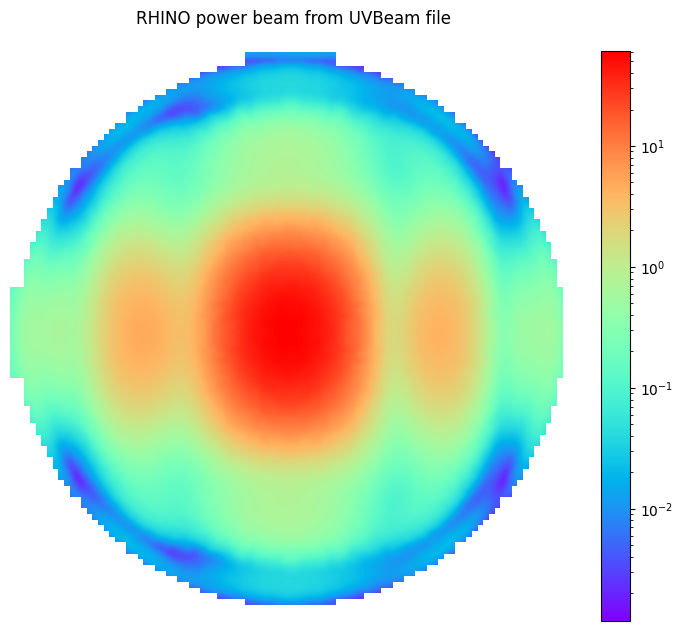

In [15]:

azimuth = rhino.axis1_array[:-1]       # Having two angles the same (0,360) does odd things
zen_angle = rhino.axis2_array[:-1]
print(azimuth.shape, zen_angle.shape)
az = np.tile(azimuth, zen_angle.size)
za = np.repeat(zen_angle, azimuth.size)
print(az.shape, za.shape)
za_ok = za<=np.deg2rad(90)
az = az[za_ok]
za = za[za_ok]

interp_beam = rhino.interp(az, za, freq_array=np.array([60e+06]))[0]
interp_beam = interp_beam[0, 0, 0, 0]       
print(interp_beam[:10])
values = interp_beam   


grid = Grid(100)
r = np.sin(za)
x = r*np.sin(az)
y = r*np.cos(az)

grid.insert(-x, y, values)
grid.average()
grid.grid = np.where(grid.grid==0, np.nan, grid.grid)


plt.figure(figsize=(8, 8))
ax = plt.axes()
ax.axis("off")
im=plt.imshow(grid.grid, interpolation="quadric", norm=LogNorm(), cmap="rainbow")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.title("RHINO power beam from UVBeam file\n")
plt.savefig("rhino_uvbeam")

In [17]:
sb = sparse_beam("NF_HERA_Vivaldi_power_beam.fits", 10, np.arange(10, dtype=int))
az = np.rad2deg(np.arange(361))
za = np.rad2deg(np.arange(91))
az = np.tile(az, za.size)
za = np.repeat(az, az.size)
vals = sb.interp(az_array=az[::100], za_array=za[::100])
print(vals.shape)     # (Naxes_vec, 1, Npols, Nfreqs, Npos)

ValueError: operands could not be broadcast together with shapes (329,1,10) (10791883,10,1) 

## What vis_cpu does

Cut out relevant code.

In [ ]:
uvb.interpolation_function = "az_za_simple"
uvb.freq_interp_kind = "linear"
uvb.polarization_array = ["XX", "YY"]

# For zenith angle of zero the second e-field component is big and the first near 0.
# For zenith angle of 90deg both values are small.
az = np.array([np.deg2rad(0)])
za = np.array([np.deg2rad(0)])
interp_beam = uvb.interp(np.array(az), np.array(za), freq_array=np.array([1.00e+08]))[0]

interp_beam = interp_beam[:, 0, :, 0, :]       # nax, nfeed, nsrcs_up

# Specify number of polarizations (axes/feeds)
polarized = True      # for this beam
if polarized:
    nax = nfeed = 2
else:
    nax = nfeed = 1
nbeam = 1
nsrcs_up = len(az)     # as in az/za length

A_s = np.zeros((nax, nfeed, nbeam, nsrcs_up), dtype=complex)

which_beam = 0
A_s[:, :, which_beam] = interp_beam
A_s = A_s.transpose((1, 2, 0, 3))  # Now (Nfeed, Nbeam, Nax, Nsrc)
#print(A_s.shape)

# Now A_s is multiplied by v that contains delays and source flux.
# A_s has shape (Nfeed, Nbeams, Nax, Nsources)
# v has shape (Nants, Nsources up) and is sqrt(I)*exp(1j tau*nu)
# Here we expand A_s to all ants (from its beams), then broadcast to v, so we
# end up with shape (Nax, Nfeed, Nants, Nsources)    WRONG
# Multiply (Nfeed, NBeam, Nax, Nsources_up) * (1, Nants, 1, Nsources up) element
# by element and because nbeam == nant we get (Nfeed, NBeam, Nax, Nsources_up)

nant = 1
v = np.ones((nant, nsrcs_up), dtype=complex)

beam_idx = [ 0 for i in range(nant) ]
v = A_s[:, beam_idx] * v[np.newaxis, :, np.newaxis, :] 
v = np.moveaxis(v, 2, 1)
print(v.shape)
v = v.reshape((nfeed * nant, nax * nsrcs_up))  # reform into matrix
print(v.shape)
print("V", v)

# Now multiplied by itself
vis = v.conj().dot(v.T)
print(vis.shape)


# Now what is the beam
for na in range(nax):
    for nf in range(nfeed):
        for ns in range(nsrcs_up):
            print("Ax", na, "Feed", nf, "Source", ns, "Beam", interp_beam[na, nf, ns], np.linalg.norm(interp_beam[na, nf, ns]))

In [ ]:
print(uvb.basis_vector_array[0, 0, :, :])
print(uvb.basis_vector_array[0, 1, :, :])
print(uvb.basis_vector_array[1, 0, :, :])
print(uvb.basis_vector_array[1, 1, :, :])